In [1]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils import data
import torch.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# sklearn classes
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# sklearn utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
%load_ext tensorboard

# Task 1

## Preprocessing

In [4]:
dataset = pd.read_csv("Task 1.csv")
dataset.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [6]:
for key in dataset.keys():
    print("Unique keys for {}: {}".format(key, dataset[key].unique()))

Unique keys for gender: ['male' 'female']
Unique keys for race/ethnicity: ['group A' 'group D' 'group E' 'group B' 'group C']
Unique keys for parental level of education: ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]
Unique keys for lunch: ['standard' 'free/reduced']
Unique keys for test preparation course: ['completed' 'none']
Unique keys for math score: [ 67  40  59  77  78  63  62  93  47  99  80  74  81  69  58  54  23  39
  83  71  44  46  51  53  33  87  65  79  68  57  98 100  60  64  52  36
  56  88  42  76  49  72  31  32  97  94  95  45  75  66  70  82  92  30
  41  43  55  73  48  86  84  50  89  91  85  61  35  90  96  13  38  28
  26  37  29  34  25]
Unique keys for reading score: [ 67  59  60  78  73  77  88  56  42  83  87  74  61  47  62  44  32  76
  52  69  55  38  45  68  89  54  79  41  65  81  75  70  46  63  72  58
  53  57  80  51  66  82  93  64  91  43  71 100  50  33  34  90  84  95
  98  92  85  

In [114]:
pre_X, y = dataset.drop(columns=['math score', 'writing score', 'reading score']), dataset[['math score', 'writing score', 'reading score']]

In [32]:
pre_X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,male,group A,high school,standard,completed
1,female,group D,some high school,free/reduced,none
2,male,group E,some college,free/reduced,none
3,male,group B,high school,standard,none
4,male,group E,associate's degree,standard,completed


In [33]:
y.head()

,math score,writing score,reading score
0,67,63,67
1,40,55,59
2,59,50,60
3,77,68,78
4,78,68,73


In [34]:
num_samples = len(dataset)
num_features = len(pre_X.keys())
num_outputs = len(y.keys())

In [115]:
X_column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), pre_X.keys()),
])

In [116]:
X = pd.DataFrame(X_column_transformer.fit_transform(pre_X))

In [117]:
X.head()

,0,1,2,3,4
0,1,1,1,1,1
1,2,2,2,2,2
2,1,3,3,2,2
3,1,4,1,1,2
4,1,3,4,1,1


In [118]:
num_features = len(X.keys())

In [193]:
y = y / 100

In [194]:
y.head()

,math score,writing score,reading score
0,0.67,0.63,0.67
1,0.40,0.55,0.59
2,0.59,0.50,0.60
3,0.77,0.68,0.78
4,0.78,0.68,0.73


In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
train_batch_size = 32
test_batch_size = 8

In [197]:
class MyDataset(torch.utils.data.Dataset):
  '''
  Prepare the Boston dataset for regression
  '''

  def __init__(self, X, y, scale_data=False):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i].float(), self.y[i].float()

In [198]:
traindataset = MyDataset(X_train.to_numpy(dtype='float64'), y_train.to_numpy(dtype='float64'))
testdataset = MyDataset(X_test.to_numpy(dtype='float64'), y_test.to_numpy(dtype='float64'))

In [199]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

In [2]:
torch.zeros(1).cuda()

d:\Programs\Anaconda\lib\site-packages\torch\cuda\__init__.py:132: UserWarning: 
    Found GPU0 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


tensor([0.], device='cuda:0')

In [3]:
%conda install pytorch torchvision torchaudio cpuonly -c pytorch

Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Programs\Anaconda

  added / updated specs:
    - cpuonly
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cpuonly-2.0                |                0           2 KB  pytorch
    torchaudio-0.13.0          |         py39_cpu         4.5 MB  pytorch
    ------------------------------------------------------------
                                           Total:         4.5 MB

The following NEW packages will be INSTALLED:

  cpuonly            pytorch/noarch::cpuonly-2.0-0 None

The following packages will be DOWNGRADED:

  pytorch                    1.13.0-py3.9_cuda11.6_cudnn8_0 --> 1.13.0-py3.9_cpu_0 None
  pytorch-mutex                                    1.0-cuda --> 1.0-cpu None
  torchaudio                              0.13.0-py39_cu116 --> 0.1

## Model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [201]:
from re import M


class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        out = self.layers(x.float())
        return out



In [202]:
# instantiate ANN
input_dim = num_features

hidden_dim = 300
output_dim = num_outputs

In [203]:
from time import time 

def train( model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    log_interval = 3

    mses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #print(target[0:1])
        output = model(data)
        #print(output[0:1])
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        temp_mse = mean_squared_error(target, output.clone().detach())
        mses.append(temp_mse)

        if batch_idx % log_interval == 0:
            print(f'\rTrain Epoch {epoch}:',
                  f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                  f'({100. * batch_idx / len(train_loader):.0f}%)]',
                  f'\tLoss: {loss.item():.6f}',
                  end='')

    mse = np.mean(mses)
    print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss/len(train_loader.dataset):.6f}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, float(mse)

In [204]:
def test( model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
    
    mse = mean_squared_error(target, output)
    print(f'\rTest set: Average loss: {test_loss/len(test_loader.dataset):.4f},',
          f'MSE: {mse:.4f}', 
          f'\n')
    
    return test_loss, float(mse)

In [205]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ANNModel(input_dim, hidden_dim, output_dim).to(device)  # Try use_dropout=False

print(f'Device: {device}')

print(model)

Device: cpu
ANNModel(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=3, bias=True)
  )
)


In [206]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy

writer = SummaryWriter(log_dir='runs/model')

epochs = 100
lr = 0.0001  # will start with big LR to see the lr_scheduler work
momentum = 0.5
log_interval = 10

criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=lr, momentum_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

best_model_wts = copy.deepcopy(model.state_dict())
best_mse = 100000.0

for epoch in range(1, epochs + 1):
    train_loss, train_mse = train(model, device, trainloader,  criterion, optimizer, epoch)
    scheduler.step(train_loss)

    test_loss, test_mse = test(model, device, testloader, criterion)

    writer.add_scalars('Loss',
                        {
                            'train': train_loss,
                            'test': test_loss
                        },
                        epoch)

    writer.add_scalars('MSE',
                        {
                            'train': train_mse,
                            'test': test_mse
                        },
                        epoch)

    # deep copy the model
    if test_mse < best_mse:
        best_mse = test_mse
        best_model_wts = copy.deepcopy(model.state_dict())
writer.close()
# we can also save every X epochs, so if our machine crashes we don't lose our progress
torch.save(model.state_dict(), "model.pt")

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_model.pt")

Train Epoch: 1 Average Loss: 0.003558, elapsed time:0.12s
Test set: Average loss: 0.0053, MSE: 0.0224 

Train Epoch: 2 Average Loss: 0.001209, elapsed time:0.09s
Test set: Average loss: 0.0044, MSE: 0.0272 

Train Epoch: 3 Average Loss: 0.001037, elapsed time:0.13s
Test set: Average loss: 0.0040, MSE: 0.0449 

Train Epoch: 4 Average Loss: 0.000958, elapsed time:0.12s
Test set: Average loss: 0.0038, MSE: 0.0160 

Train Epoch: 5 Average Loss: 0.000899, elapsed time:0.11s
Test set: Average loss: 0.0036, MSE: 0.0128 

Train Epoch: 6 Average Loss: 0.000856, elapsed time:0.10s
Test set: Average loss: 0.0035, MSE: 0.0345 

Train Epoch: 7 Average Loss: 0.000817, elapsed time:0.13s] 	Loss: 0.017332
Test set: Average loss: 0.0035, MSE: 0.0158 

Train Epoch: 8 Average Loss: 0.000785, elapsed time:0.09s
Test set: Average loss: 0.0032, MSE: 0.0093 

Train Epoch: 9 Average Loss: 0.000739, elapsed time:0.11s
Test set: Average loss: 0.0032, MSE: 0.0347 

Train Epoch: 10 Average Loss: 0.000720, elapsed

In [207]:
data = MyDataset(X_test.to_numpy(), y_test.to_numpy())
model = ANNModel(input_dim, hidden_dim, output_dim).to(device)
model.load_state_dict(best_model_wts)
output = model(data.X)
display(output[10:20], y_test[10:20])

tensor([[0.6859, 0.6289, 0.6624],
        [0.6298, 0.6786, 0.6926],
        [0.6831, 0.6277, 0.6449],
        [0.6896, 0.6354, 0.6454],
        [0.5127, 0.4902, 0.5253],
        [0.5440, 0.4827, 0.5433],
        [0.7748, 0.6618, 0.6998],
        [0.6530, 0.7115, 0.7109],
        [0.6713, 0.6446, 0.6704],
        [0.7883, 0.6826, 0.7107]], grad_fn=<SliceBackward0>)

,math score,writing score,reading score
811,0.56,0.56,0.65
76,0.47,0.59,0.63
636,0.63,0.56,0.56
973,0.78,0.67,0.71
938,0.45,0.32,0.33
899,0.45,0.27,0.31
280,0.85,0.80,0.81
883,0.70,0.80,0.78
761,0.70,0.73,0.79
319,0.83,0.79,0.85


: 

In [191]:
print(best_mse)

86.28436279296875


In [196]:
print(mean_squared_error(y_test, output.detach()))

0.47931605606162014


In [197]:
from torchvision import datasets

In [246]:
# create image transforms

from torchvision import transforms

transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),
    transforms.RandomRotation((-45, 45))
])

test_dataset = datasets.ImageFolder(root='triple_mnist/test', transform=transform)

train_dataset = datasets.ImageFolder(root='triple_mnist/train', transform=transform)

val_dataset = datasets.ImageFolder(root='triple_mnist/val', transform=transform)



In [247]:
# create dataset loaders

from torch.utils.data import DataLoader

batch_size = 128

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [248]:
dataloaders = {'train': train_loader, 'val': val_loader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [249]:
image_datasets = {'train': train_dataset, 'val': val_dataset}

In [250]:
print(len(train_dataset[0][0][0][0]))

84


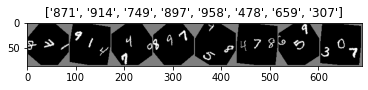

In [251]:
import torchvision
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = image_datasets['train'].classes
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:8])

imshow(out,title=[class_names[x] for x in classes][0:8])

In [252]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print(len(dataloaders[phase]))
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.view(-1, 84 * 84 * 3))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [253]:
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import time
import os
import copy

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model_ft = ANNModel(84 * 84 * 3, 84, 1000)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [254]:
print(train_dataset[0][0].shape)

torch.Size([3, 84, 84])


In [255]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
500


KeyboardInterrupt: 

: 